In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis
from Generate_data_activity import Generate_data

sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif")

from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import seaborn as sns
import cv2
from tabulate import tabulate


import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


Device:  cpu


# A2C model

In [2]:
LENGTH_TRIAL = 500
EPISODES = 1

In [3]:
Generate_DATA = Generate_data(device)
Liste_activation,Final_score,Liste_position_agent,Liste_position_alien,Liste_action_agent= Generate_DATA.run_episodes(structure_network = "a2c",length_trial = LENGTH_TRIAL,number_episode = EPISODES)

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_1000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_2000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_3000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_4000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_5000.pt


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.



Episode :0 	Agent number :0 	Final score: 155.00 	Number of steps: 830
Episode :0 	Agent number :1 	Final score: 270.00 	Number of steps: 1003
Episode :0 	Agent number :2 	Final score: 215.00 	Number of steps: 729
Episode :0 	Agent number :3 	Final score: 230.00 	Number of steps: 819
Episode :0 	Agent number :4 	Final score: 285.00 	Number of steps: 1053
Episode :0 	Agent number :5 	Final score: 110.00 	Number of steps: 506

## Preprocessing

In [4]:
Names_hook = ["Conv_1","Conv_2","Conv_3","fc1"]
analysis = Manifold_analysis(LENGTH_TRIAL)
Prepro_length = True
activity_layer = [[[[] for i in range(len(Names_hook))] for j in range(6)] for episode in range(EPISODES)]

for agent_number in range(6):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        for episode in range(EPISODES):
            activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer],Prepro_length)

agent_number 0
agent_number 1
agent_number 2
agent_number 3
agent_number 4
agent_number 5


## PCA

In [5]:

#fig = plt.figure(figsize=(20, 10))

L_threshold = [[[] for i in range(len(Names_hook))] for j in range(6)] 


for agent_number in range(6):    
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):

            X = np.transpose(activity_layer[episode][agent_number][i])
            pca = PCA(n_components = 50) #we have 20 features
            pca.fit(X)
            variance = pca.explained_variance_ratio_ #calculate variance ratios
            var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
            #var #cumulative sum of variance explained with [n] features
            threshold = [i for i in range(len(var)) if var[i]>90]
            L_threshold[agent_number][i].append(threshold[0])


## Etude de l'influence de l'entrainement sur la dimension du manifold

In [6]:
table = [["Init"],["1000"],["2000"],["3000"],["4000"],["5000"]]

for agent_number in range(6):
    for i in range(len(Names_hook)):
        table[agent_number].append(np.mean(L_threshold[agent_number][i]))

        
print(tabulate(table, headers=["# Training Epoch","Conv_1","Conv_2","Conv_3","fc1"],tablefmt ="fancy_grid"))

╒════════════════════╤══════════╤══════════╤══════════╤═══════╕
│ # Training Epoch   │   Conv_1 │   Conv_2 │   Conv_3 │   fc1 │
╞════════════════════╪══════════╪══════════╪══════════╪═══════╡
│ Init               │        8 │        4 │        0 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 1000               │        7 │        3 │        0 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 2000               │        5 │        2 │        2 │     0 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 3000               │        7 │        5 │        3 │     2 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 4000               │        7 │        5 │        2 │     1 │
├────────────────────┼──────────┼──────────┼──────────┼───────┤
│ 5000               │        5 │        4 │        3 │     1 │
╘════════════════════╧══════════╧══════════╧══════════╧═══════╛


# Canonical Covariance Anaysis

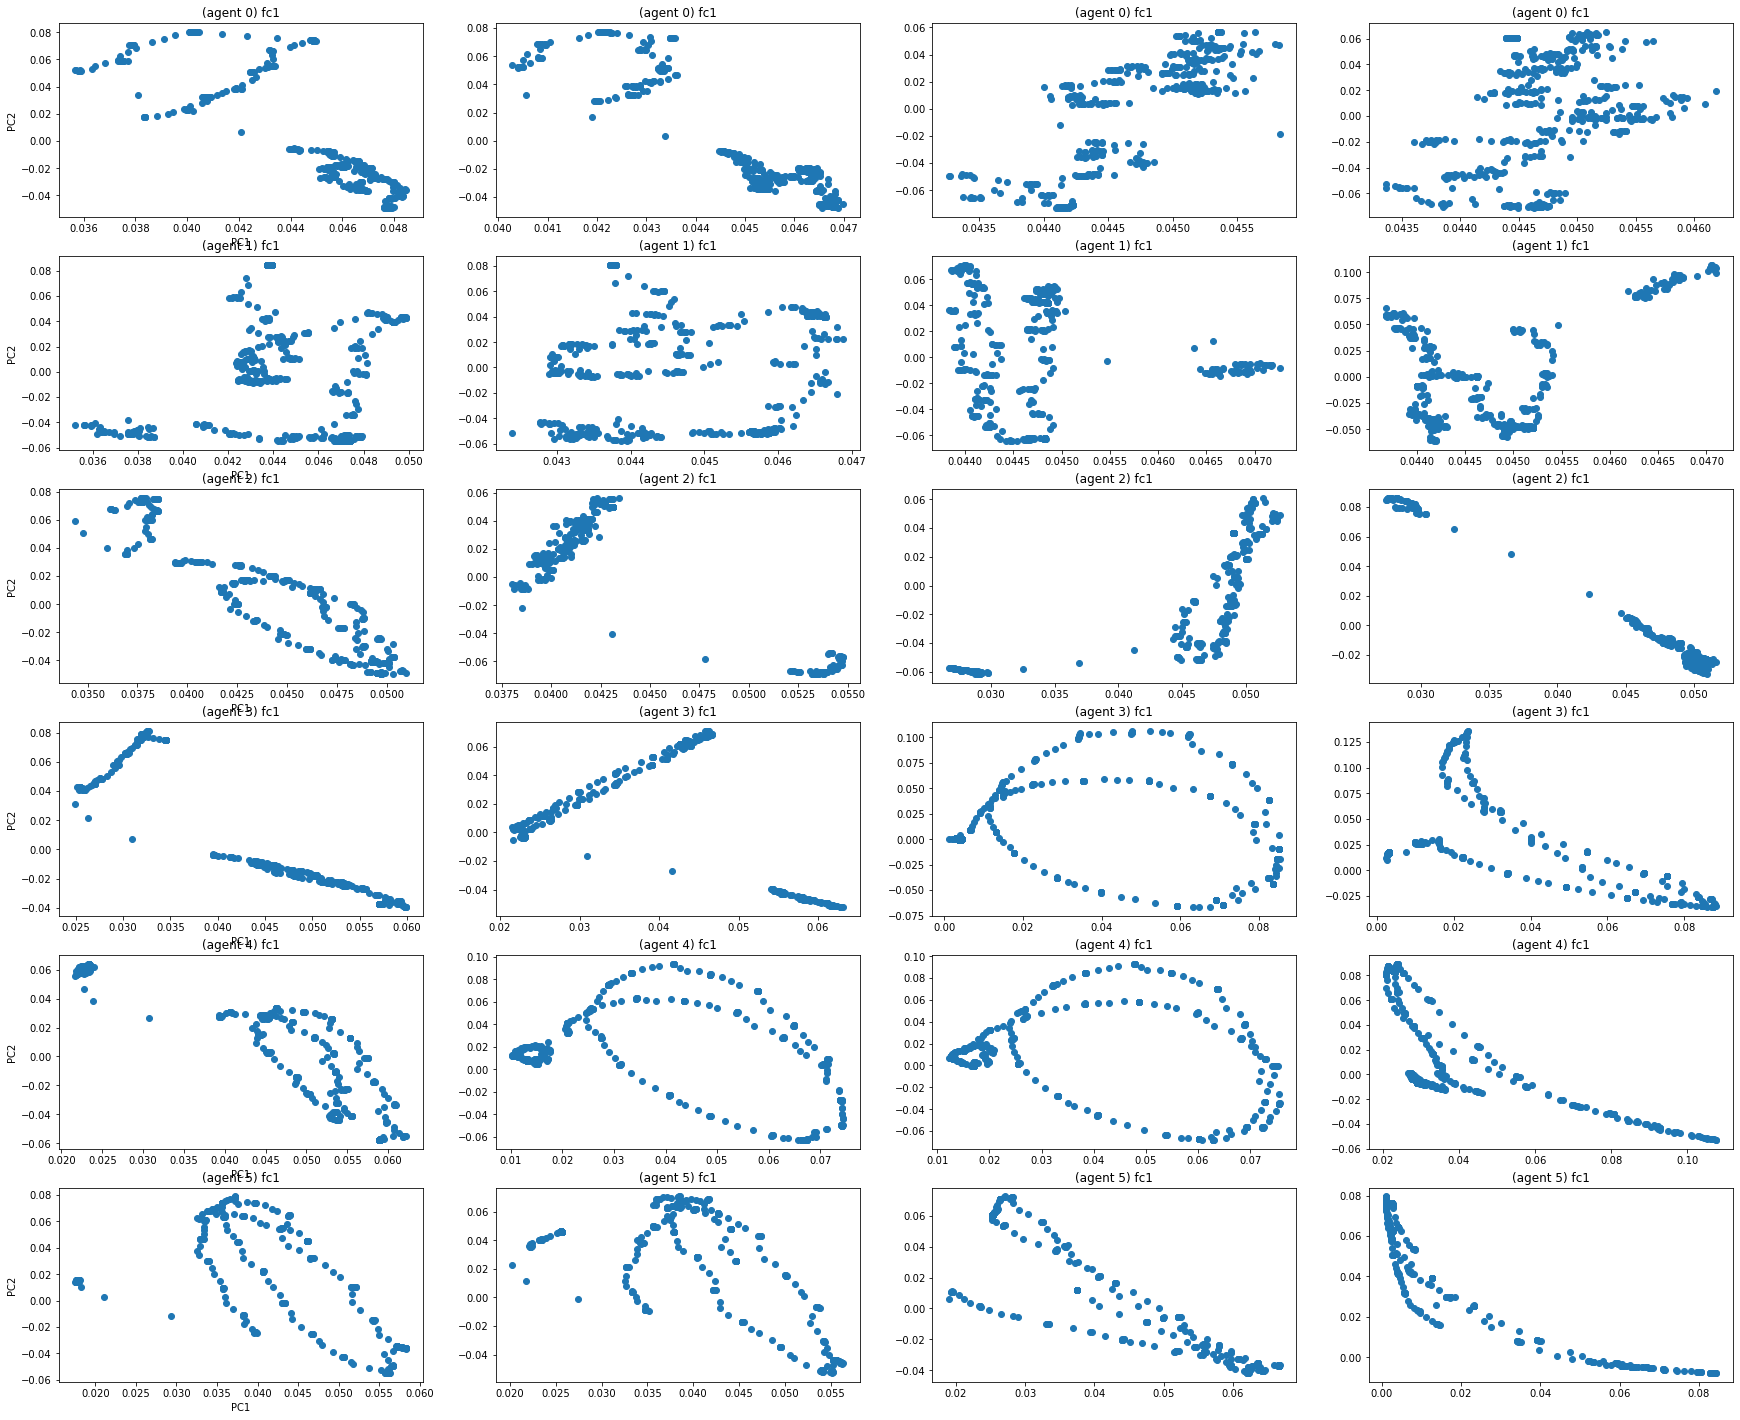

In [7]:
j=1
fig = plt.figure(figsize=(30,25))
for agent_number in range(6):
    for i in range(len(Names_hook)):
        X = np.transpose(activity_layer[0][agent_number][i])
        pca = PCA(n_components = 10) #we have 20 features
        pca.fit(X)
        ax = fig.add_subplot(6,len(Names_hook),j)
        ax.scatter(pca.components_[0],pca.components_[1])
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))           # plt.suptitle(table[agent_number][0], fontsize=20)


        
        if i ==0:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            
        j+=1
        



In [8]:
episode_s = 0
agent_s = 0

In [9]:
position_agent_s = Liste_position_agent[episode_s][agent_s]
position_alien_s = Liste_position_alien[episode_s][agent_s]
Liste_action_agent_s = Liste_action_agent[episode_s][agent_s]

In [10]:
print(len(position_agent_s[0:500]))

500


## Creata DataFrame

In [37]:
import pandas as pd  
  
# assign data of lists.  
data = {'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],'PC4':pca.components_[3],'PC5':pca.components_[4], 'Agent_Position':position_agent_s[0:500],'Alien_Position':position_alien_s[0:500],'Liste_action_agent':Liste_action_agent_s[0:500]}  


#data = {'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2], 'Alien_Position':[np.random.randint(100) for i in range(500)],'Agent_Position':[np.random.randint(100) for i in range(500)],'Liste_action_agent':Liste_action_agent_s[0:500]}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =[str(i) for i in range(500)])  
  
# print the data  


## Standardization

In [39]:
X = df[['PC1','PC2','PC3','PC4','PC5']]
Y = df[["Agent_Position","Alien_Position"]]

X_mc = (X-X.mean())/(X.std())
Y_mc = (Y-Y.mean())/(Y.std())

In [40]:
ca = CCA()
ca.fit(X_mc, Y_mc)
X_c, Y_c = ca.transform(X_mc, Y_mc)

In [41]:
print(X_c.shape)
print(Y_c.shape)

(500, 2)
(500, 2)


In [42]:
cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "Actions":df.Liste_action_agent.tolist(),
                      })

In [25]:
np.corrcoef(X_c[:, 1], Y_c[:, 1])

array([[1.        , 0.39732341],
       [0.39732341, 1.        ]])

In [26]:
np.corrcoef(X_c[:, 0], Y_c[:, 0])

array([[1.        , 0.61593664],
       [0.61593664, 1.        ]])

Text(0.5, 1.0, 'Comp. 1, corr = 0.62')

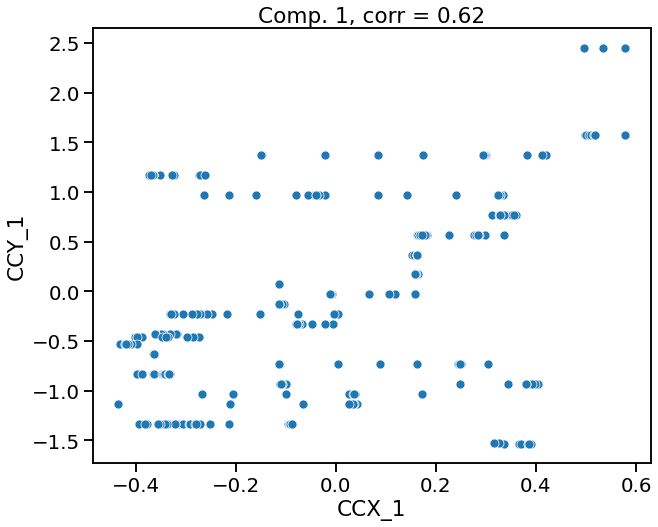

In [27]:
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(10,8))
sns.scatterplot(x="CCX_1",
                y="CCY_1", 
                data=cc_res)
plt.title('Comp. 1, corr = %.2f' %
         np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])

Text(0.5, 1.0, 'Comp. 1, corr = 0.40')

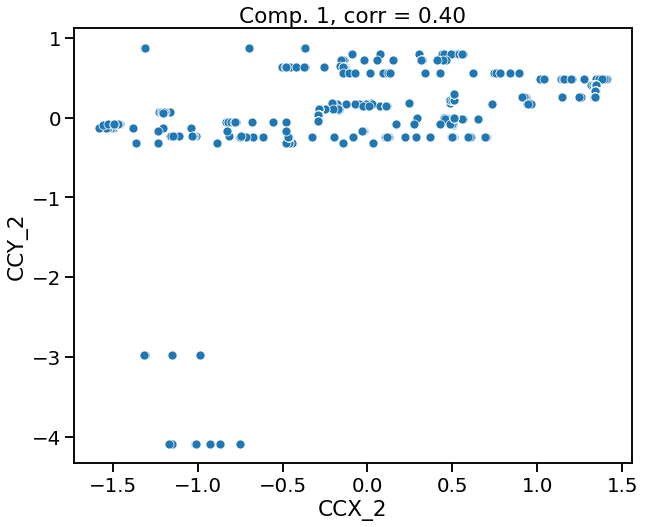

In [28]:
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(10,8))
sns.scatterplot(x="CCX_2",
                y="CCY_2", 
                data=cc_res)
plt.title('Comp. 1, corr = %.2f' %
         np.corrcoef(X_c[:, 1], Y_c[:, 1])[0, 1])

Text(0.5, 1.0, 'First Pair of Canonical Covariate, corr = 0.62')

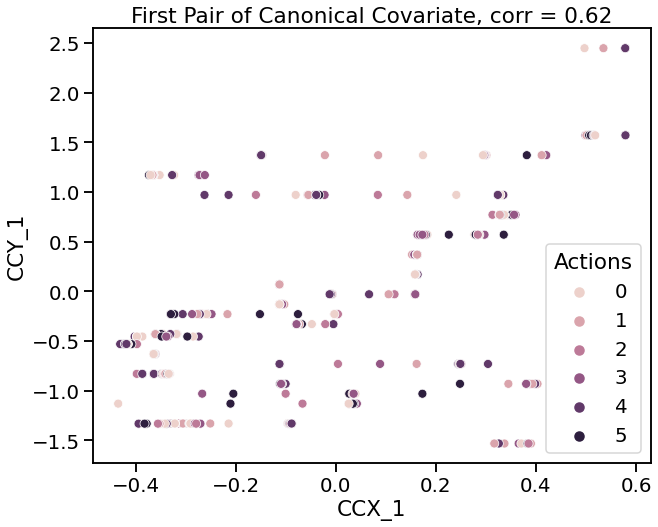

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="CCX_1",
                y="CCY_1", 
                hue="Actions", data=cc_res)
plt.title('First Pair of Canonical Covariate, corr = %.2f' %
         np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])

In [30]:
ccY_df = pd.DataFrame({"CCY_1":Y_c[:, 0],
                       "CCY_2":Y_c[:, 1],
                       "Actions":df.Liste_action_agent.astype('category').cat.codes,
                       "Agent_Position":Y_mc.Agent_Position,
                      "Alien_Position":Y_mc.Alien_Position})

In [31]:
corr_Y_df= ccY_df.corr(method='pearson') 
corr_Y_df.head()

,CCY_1,CCY_2,Actions,Agent_Position,Alien_Position
CCY_1,1.000000e+00,-1.239993e-15,0.036019,0.386782,-0.979255
CCY_2,-1.239993e-15,1.000000e+00,0.011056,-0.922171,-0.202633
Actions,3.601885e-02,1.105591e-02,1.000000,0.003736,-0.037512
Agent_Position,3.867823e-01,-9.221711e-01,0.003736,1.000000,-0.191896
Alien_Position,-9.792546e-01,-2.026335e-01,-0.037512,-0.191896,1.000000


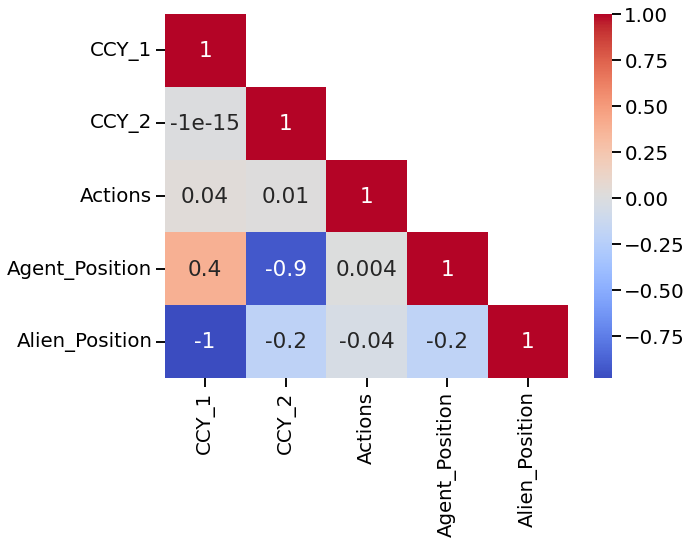

In [32]:
plt.figure(figsize=(10,8))
Y_df_lt = corr_Y_df.where(np.tril(np.ones(corr_Y_df.shape)).astype(np.bool))

sns.heatmap(Y_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_Y_and_data.jpg",
                    format='jpeg',
                    dpi=100)

In [33]:
ccX_df = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "Actions":df.Liste_action_agent.astype('category').cat.codes,
                       "PC1":X_mc.PC1,
                      "PC2":X_mc.PC2,
                      "PC3":X_mc.PC3,
                      "PC4":X_mc.PC4,
                      "PC5":X_mc.PC5,
                      "Agent_Position":Y_mc.Agent_Position,
                      "Alien_Position":Y_mc.Alien_Position})

In [34]:
corr_X_df= ccX_df.corr(method='pearson') 
corr_X_df.head()

,CCX_1,CCX_2,Actions,PC1,PC2,PC3,PC4,PC5,Agent_Position,Alien_Position
CCX_1,1.000000e+00,-5.618892e-08,0.056980,0.020154,0.016160,-0.508878,-0.255151,-0.690912,0.238233,-0.603159
CCX_2,-5.618892e-08,1.000000e+00,0.018102,0.483067,-0.132300,0.529870,0.589687,-0.383448,-0.366207,-0.080999
Actions,5.697965e-02,1.810247e-02,1.000000,0.051294,-0.046275,-0.023559,-0.020378,-0.022484,0.003736,-0.037512
PC1,2.015352e-02,4.830671e-01,0.051294,1.000000,-0.914316,0.042323,0.169182,-0.048315,-0.172101,-0.051284
PC2,1.615980e-02,-1.322999e-01,-0.046275,-0.914316,1.000000,0.039943,0.159669,-0.045598,0.052299,0.000969


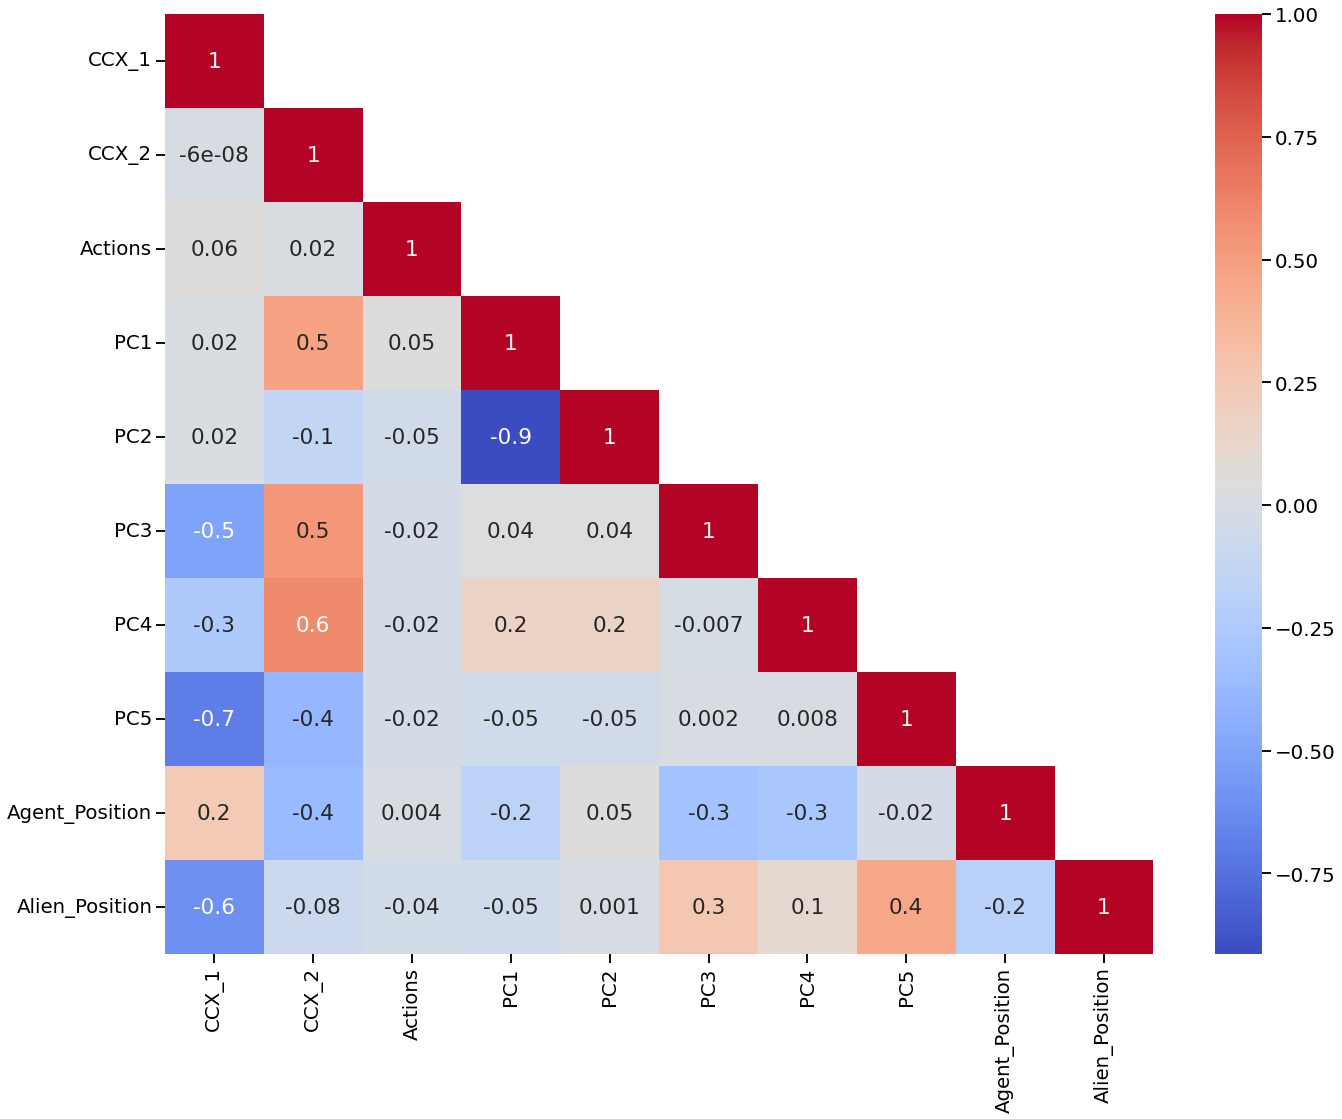

In [35]:
plt.figure(figsize=(20,16))
X_df_lt = corr_X_df.where(np.tril(np.ones(corr_X_df.shape)).astype(np.bool))
sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_X_and_data.jpg",
                    format='jpeg',
                    dpi=100)


In [36]:
for k in range(4,5):
    print(k)

4


In [114]:
SBP = [120,109,130,121,135,140]
DBP = [76,80,82,78,85,87]
Height = [165,180,170,185,180,187]
Weight = [60,80,70,85,90,87]

In [115]:
data = {'SBP':SBP,'DBP':DBP,'Height':Height,'Weight':Weight}  

# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =[str(i) for i in range(len(SBP))])  

In [116]:
X = df[['SBP','DBP']]
Y = df[['Height','Weight']]

#X_mc = (X-X.mean())/(X.std())
#Y_mc = (Y-Y.mean())/(Y.std())

In [124]:
ca = CCA(n_components=2,scale=False)
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

In [135]:
print("X_c_1",X_c[:, 0])
print("X_c_2",X_c[:, 1])

X_c_1 [-4.52259716  0.88490731  0.11469207 -2.67095016  2.43333669  3.76061125]
X_c_2 [  3.57499153 -18.83067031   3.96305696   0.71093904   4.15708967
   6.42459312]


In [127]:
print(ca.coef_)

[[-1.29027379 -0.75214073]
 [ 2.85551369  2.43959707]]


In [139]:
valeur = 120*-1.29 + 75*-0.75
print(valeur)

-211.05


In [129]:
print(ca.x_loadings_)

[[2.07347074 0.99137006]
 [1.28288899 0.13109311]]


In [128]:
print(ca.feature_names_in_)

['SBP' 'DBP']


In [130]:
print(ca.y_loadings_)

[[ 0.9879621  -0.90480063]
 [ 1.5701904  -0.42583543]]


In [131]:
cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1]
                      })

In [136]:
print("Y_c_1",Y_c[:, 0])
print("Y_c_2",Y_c[:, 1])

Y_c_1 [-11.42472374   0.2837574   -4.50589459   2.6785834    9.33176373
   3.6365138 ]
Y_c_2 [ 1.70881758 -2.0847964   3.7374866  -4.9959379   7.79482464 -6.1603945 ]
